# Przygotowanie danych finansowych 
dla indeksu SP500 i Apple, który się w nim znajduje z Yahoo Finance

In [1]:
# pip install yfinance

In [2]:
import numpy as np
np.random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import yfinance as yf
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


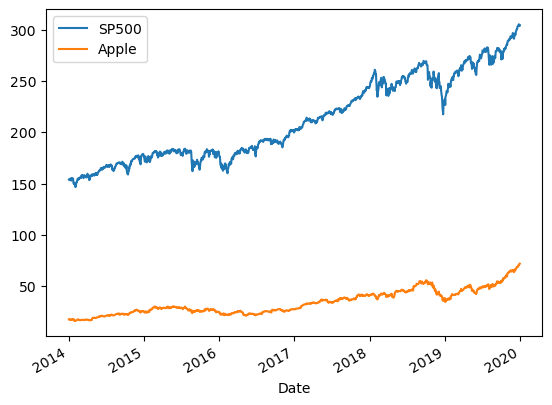

In [3]:
sp500 = yf.download('SPY','2014-01-01', end='2020-01-01')
apple = yf.download('AAPL','2014-01-01', end='2020-01-01')

sp500['Adj Close'].plot(label='SP500')
apple['Adj Close'].plot(label='Apple')
plt.legend()
plt.show()

In [4]:
apple_adj = apple[['Adj Close']]
sp500_adj = sp500[['Adj Close']]
apple_adj = apple_adj.rename(columns={'Adj Close': 'Adj Close Apple'})
sp500_adj = sp500_adj.rename(columns={'Adj Close': 'Adj Close SP500'})

Łączenie danych w jeden dataframe

In [5]:
df = pd.concat([sp500_adj, apple_adj], join = 'outer', axis = 1)
df

Adj Close SP500  Adj Close Apple
Date                                        
2014-01-02       153.828873        17.364962
2014-01-03       153.803528        16.983528
2014-01-06       153.357880        17.076139
2014-01-07       154.299759        16.954012
2014-01-08       154.333405        17.061386
...                     ...              ...
2019-12-24       303.931671        69.421059
2019-12-26       305.549622        70.798416
2019-12-27       305.473907        70.771538
2019-12-30       303.789764        71.191566
2019-12-31       304.527771        71.711754

[1510 rows x 2 columns]

Normalizowanie cen akcji

In [6]:
def normalize_stocks(df):
    df_ = df.copy() # it is a good idea in general to make a copy
    first_row = df_.iloc[0]
    for stock in df_.columns:
        df_[stock] = df_[stock] / first_row[stock]
    return df_

In [7]:
df = normalize_stocks(df)
df

Adj Close SP500  Adj Close Apple
Date                                        
2014-01-02         1.000000         1.000000
2014-01-03         0.999835         0.978034
2014-01-06         0.996938         0.983368
2014-01-07         1.003061         0.976335
2014-01-08         1.003280         0.982518
...                     ...              ...
2019-12-24         1.975778         3.997766
2019-12-26         1.986296         4.077085
2019-12-27         1.985803         4.075537
2019-12-30         1.974855         4.099725
2019-12-31         1.979653         4.129681

[1510 rows x 2 columns]

Plot trendu cen akcji Apple i SP500

In [8]:
import plotly.express as px
fig = px.line(title = "Normalized stock prices")

for stock in df.columns:
    fig.add_scatter(x = df.index, y = df[stock], name = stock)
fig.show()

Liczy dzienny zwrot z akcji

In [9]:
def daily_return_from_stock(df):
  df_=df.copy()
  df_c = [col for col in df_.columns if 'Adj Close' in col]
  for column in df_c:
    df_['Daily Return '+column.replace("Adj Close ", "")] = df[column].pct_change()

  return df_

In [10]:
df = daily_return_from_stock(df)
df

Adj Close SP500  Adj Close Apple  Daily Return SP500  \
Date                                                               
2014-01-02         1.000000         1.000000                 NaN   
2014-01-03         0.999835         0.978034           -0.000165   
2014-01-06         0.996938         0.983368           -0.002898   
2014-01-07         1.003061         0.976335            0.006142   
2014-01-08         1.003280         0.982518            0.000218   
...                     ...              ...                 ...   
2019-12-24         1.975778         3.997766            0.000031   
2019-12-26         1.986296         4.077085            0.005323   
2019-12-27         1.985803         4.075537           -0.000248   
2019-12-30         1.974855         4.099725           -0.005513   
2019-12-31         1.979653         4.129681            0.002429   

            Daily Return Apple  
Date                            
2014-01-02                 NaN  
2014-01-03           -0.021966  
2014-01-06            0.005453  
2014-01-07           -0.007152  
2014-01-08            0.006333  
...                        ...  
2019-12-24            0.000950  
2019-12-26            0.019841  
2019-12-27           -0.000380  
2019-12-30            0.005935  
2019-12-31            0.007307  

[1510 rows x 4 columns]

In [11]:
df['Variance'] = df['Daily Return SP500'].rolling(window=len(df), min_periods=1).var().shift(1)

In [12]:
df['Covariance'] = df['Daily Return SP500'].rolling(window=len(df), min_periods=1).cov(df['Daily Return Apple']).shift(1)

In [13]:
df['Beta'] = df['Covariance']/df['Variance']

In [14]:
df

Adj Close SP500  Adj Close Apple  Daily Return SP500  \
Date                                                               
2014-01-02         1.000000         1.000000                 NaN   
2014-01-03         0.999835         0.978034           -0.000165   
2014-01-06         0.996938         0.983368           -0.002898   
2014-01-07         1.003061         0.976335            0.006142   
2014-01-08         1.003280         0.982518            0.000218   
...                     ...              ...                 ...   
2019-12-24         1.975778         3.997766            0.000031   
2019-12-26         1.986296         4.077085            0.005323   
2019-12-27         1.985803         4.075537           -0.000248   
2019-12-30         1.974855         4.099725           -0.005513   
2019-12-31         1.979653         4.129681            0.002429   

            Daily Return Apple  Variance  Covariance       Beta  
Date                                                             
2014-01-02                 NaN       NaN         NaN        NaN  
2014-01-03           -0.021966       NaN         NaN        NaN  
2014-01-06            0.005453       NaN         NaN        NaN  
2014-01-07           -0.007152  0.000004   -0.000037 -10.033353  
2014-01-08            0.006333  0.000021   -0.000016  -0.740188  
...                        ...       ...         ...        ...  
2019-12-24            0.000950  0.000068    0.000081   1.193538  
2019-12-26            0.019841  0.000068    0.000081   1.193536  
2019-12-27           -0.000380  0.000068    0.000081   1.194151  
2019-12-30            0.005935  0.000068    0.000081   1.194155  
2019-12-31            0.007307  0.000068    0.000081   1.193449  

[1510 rows x 7 columns]

# Przeprowadzanie eksperymentu

In [15]:
r2_scores = []
mse_scores = []
mae_scores = []

df = df.dropna()

split_date = '2019-01-01'
split_date = pd.to_datetime(split_date)
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]

In [16]:
# dodanie cech czasu dla datasetu
def create_time_features(df, target):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    
    y = df[target]
    X = X.drop([target], axis=1)
    return X, y

In [17]:
X_train_df, y_train = create_time_features(
    df_training, target='Beta')
X_test_df, y_test = create_time_features(df_test, target='Beta')
scaler = StandardScaler()
scaler.fit(X_train_df)
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

C:\Users\abc\AppData\Local\Temp\ipykernel_18420\959883166.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\abc\AppData\Local\Temp\ipykernel_18420\959883166.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\abc\AppData\Local\Temp\ipykernel_18420\959883166.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

## Parametry domyślne

### Linear Regression

In [18]:
lin = LinearRegression()
lin.fit(X_train, y_train) 
lin_predict = lin.predict(X_test)

r2_scores.append(r2_score(df_test.Beta.values, lin_predict))
mae_scores.append(mean_absolute_error(df_test.Beta.values, lin_predict))
mse_scores.append(mean_squared_error(df_test.Beta.values, lin_predict))

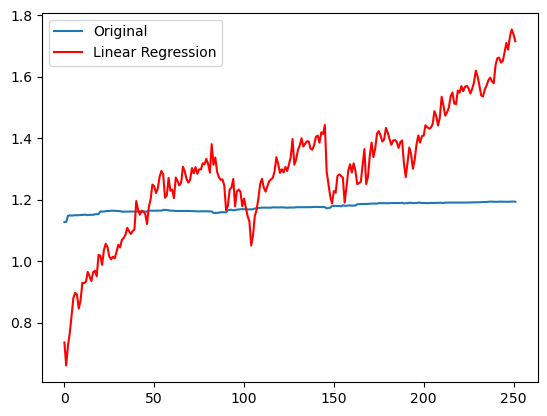

In [19]:
plt.plot(df_test.Beta.values, label='Original')
plt.plot(lin_predict, color='red', label='Linear Regression')
plt.legend();

### Random Forest

In [20]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

r2_scores.append(r2_score(df_test.Beta.values, forest_pred))
mae_scores.append(mean_absolute_error(df_test.Beta.values, forest_pred))
mse_scores.append(mean_squared_error(df_test.Beta.values, forest_pred))

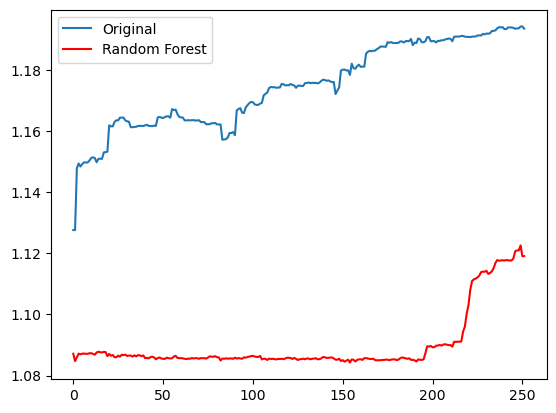

In [21]:
plt.plot(df_test.Beta.values, label='Original');
plt.plot(forest_pred, color='red', label='Random Forest');
plt.legend();

In [22]:
r2_score(df_test.Beta.values, forest_pred)

-36.53190609440176

In [23]:
mean_absolute_error(df_test.Beta.values, forest_pred)

0.08461055488720873

In [24]:
mean_squared_error(df_test.Beta.values, forest_pred)

0.007309983430889099

### KNN

In [25]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

r2_scores.append(r2_score(df_test.Beta.values, knn_pred))
mae_scores.append(mean_absolute_error(df_test.Beta.values, knn_pred))
mse_scores.append(mean_squared_error(df_test.Beta.values, knn_pred))

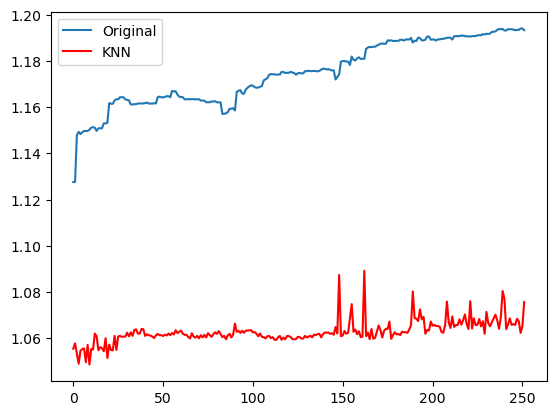

In [26]:
plt.plot(df_test.Beta.values, label='Original');
plt.plot(knn_pred, color='red', label='KNN');
plt.legend();

In [27]:
r2_score(df_test.Beta.values, knn_pred)

-64.12744112223612

In [28]:
mean_absolute_error(df_test.Beta.values, knn_pred)

0.11202088313664557

In [29]:
mean_squared_error(df_test.Beta.values, knn_pred)

0.012684687910661784

### MLP

In [30]:
mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_shape=(16,)))
mlp.add(Dense(1))
mlp.compile(optimizer='adam', loss='mae')

mlp.fit(X_train, y_train, epochs=30, verbose=0)

mlp_pred = mlp.predict(X_test, verbose=0)

In [31]:
r2_scores.append(r2_score(df_test.Beta.values, mlp_pred))
mae_scores.append(mean_absolute_error(df_test.Beta.values, mlp_pred))
mse_scores.append(mean_squared_error(df_test.Beta.values, mlp_pred))

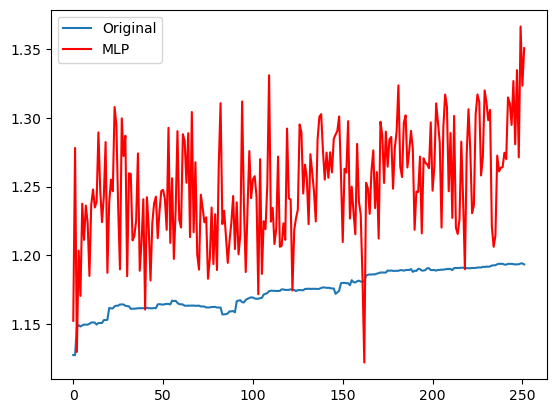

In [32]:
plt.plot(df_test.Beta.values, label='Original');
plt.plot(mlp_pred, color='red', label='MLP');
plt.legend();

In [33]:
r2_score(df_test.Beta.values, mlp_pred)

-35.18686138595599

### RNN - Tensorflow LSTM

In [34]:
# pip install tensorflow

In [35]:
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24

# długość zestawu danych zostanie zmniejszona, aby zagwarantować, że wszystkie próbki będą miały "okno", 
# więc nową długością będzie len(dataset)-window
def window_data(X, Y, window=7):
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)

# łaczymy datasety, aby odpowiednio zorganizować ich długosć według długości okna
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [36]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='Adam', loss='mae')

In [37]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 10s 33ms/step - loss: 0.2468 - val_loss: 0.1116
Epoch 2/30
200/200 [==============================] - 6s 32ms/step - loss: 0.0985 - val_loss: 0.0409
Epoch 3/30
200/200 [==============================] - 7s 33ms/step - loss: 0.0588 - val_loss: 0.0832
Epoch 4/30
200/200 [==============================] - 7s 33ms/step - loss: 0.0695 - val_loss: 0.0570
Epoch 5/30
200/200 [==============================] - 7s 36ms/step - loss: 0.0869 - val_loss: 0.0645
Epoch 6/30
200/200 [==============================] - 7s 36ms/step - loss: 0.0674 - val_loss: 0.1294
Epoch 7/30
200/200 [==============================] - 7s 37ms/step - loss: 0.0660 - val_loss: 0.0378
Epoch 8/30
200/200 [==============================] - 7s 34ms/step - loss: 0.0502 - val_loss: 0.0430
Epoch 9/30
200/200 [==============================] - 7s 36ms/step - loss: 0.0372 - val_loss: 0.0628
Epoch 10/30
200/200 [==============================] - 7s 33ms/step - loss: 0.0557 - val_l

In [38]:
lstm_pred = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]

r2_scores.append(r2_score(df_test.Beta.values, lstm_pred))
mae_scores.append(mean_absolute_error(df_test.Beta.values, lstm_pred))
mse_scores.append(mean_squared_error(df_test.Beta.values, lstm_pred))

8/8 [==============================] - 1s 10ms/step


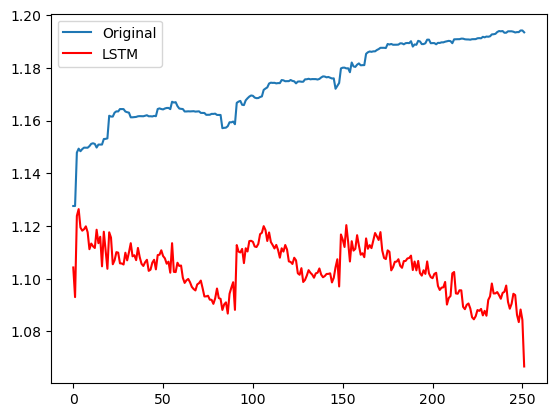

In [39]:
plt.plot(df_test.Beta.values, label='Original');
plt.plot(lstm_pred, color='red', label='LSTM');
plt.legend();

In [40]:
r2_score(df_test.Beta.values, lstm_pred)

-26.80989979025426

### Wykresy błędów

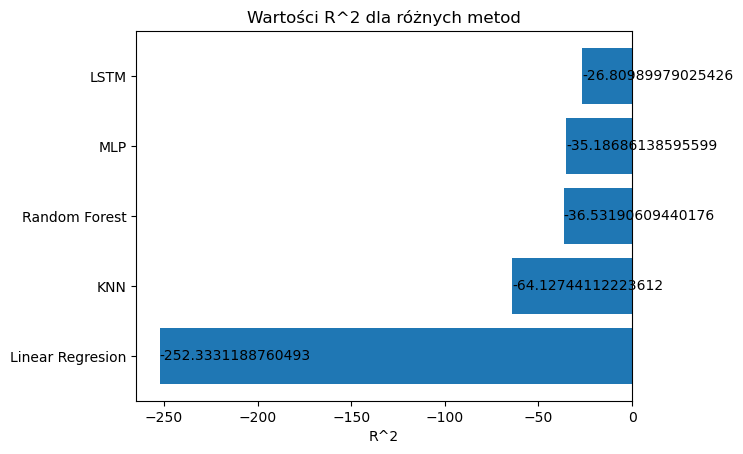

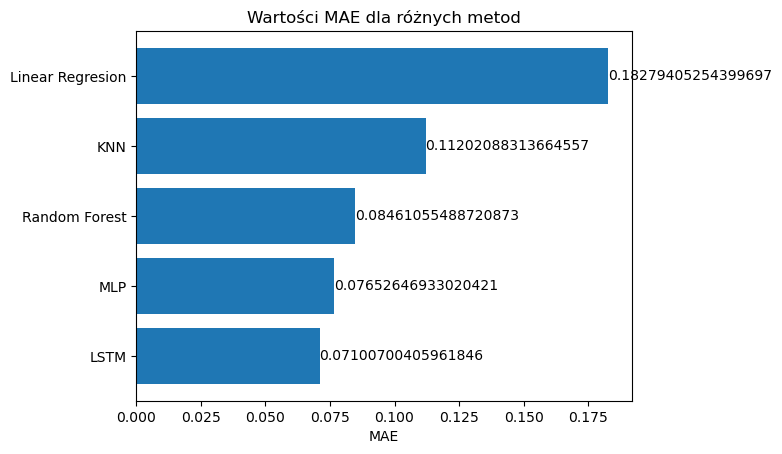

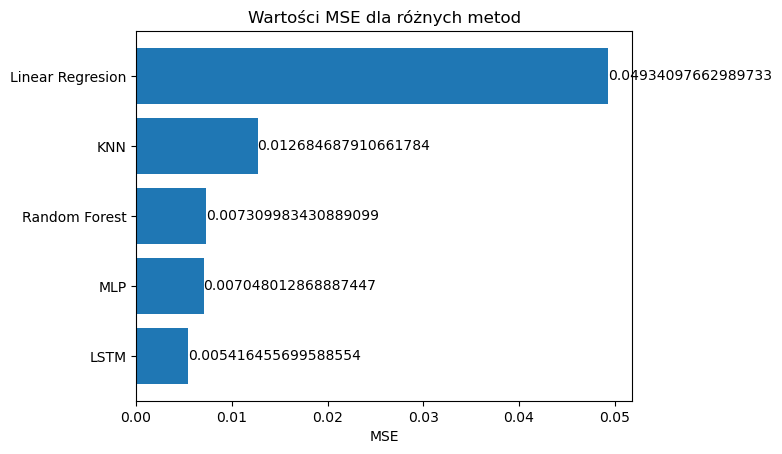

In [41]:
scores_list = [r2_scores, mae_scores, mse_scores]
names_list = ['R^2', 'MAE', 'MSE']
methods = ['Linear Regresion', 'Random Forest', 'KNN', 'MLP', 'LSTM']

for scores, name in zip(scores_list, names_list):
    sorted_data = sorted(zip(scores, methods))

    sorted_r2_scores, sorted_methods = zip(*sorted_data)
    
    plt.barh(range(len(sorted_r2_scores)), sorted_r2_scores)

    plt.yticks(range(len(sorted_methods)), sorted_methods)

    for i, score in enumerate(sorted_r2_scores):
        plt.text(score, i, str(score), ha='left', va='center')

    plt.title(f'Wartości {name} dla różnych metod')
    plt.xlabel(name)

    plt.show()

## Parametry zmienione

### Random Forest

In [42]:
forest = RandomForestRegressor(random_state=42, n_estimators=9, max_depth=15, criterion='absolute_error',
                               min_samples_split=4)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

In [43]:
r2_score(df_test.Beta.values, forest_pred)

-16.044332740678882

In [44]:
mean_absolute_error(df_test.Beta.values, knn_pred)

0.11202088313664557

In [45]:
mean_squared_error(df_test.Beta.values, knn_pred)

0.012684687910661784

### KNN

In [46]:
knn = KNeighborsRegressor(n_neighbors=1, algorithm='kd_tree', p=1)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

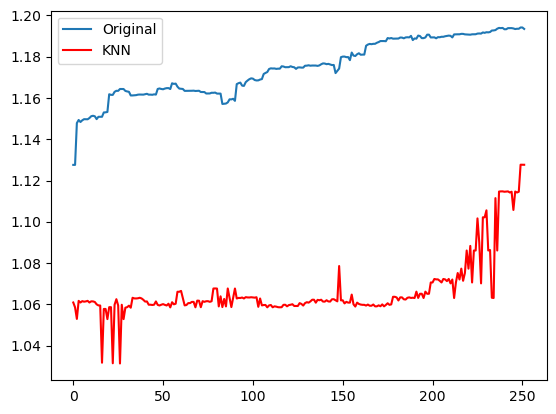

In [47]:
plt.plot(df_test.Beta.values, label='Original');
plt.plot(knn_pred, color='red', label='KNN');
plt.legend();

In [48]:
r2_score(df_test.Beta.values, knn_pred)

-59.725711907023886

In [49]:
mean_absolute_error(df_test.Beta.values, knn_pred)

0.10782418282207883

In [50]:
mean_squared_error(df_test.Beta.values, knn_pred)

0.01182737553357307

### MLP

In [51]:
def build_mlp(opt):
    mlp = Sequential()
    mlp.add(Dense(128, activation='relu', input_shape=(16,)))
    mlp.add(Dense(1))
    
    mlp.compile(optimizer=opt, loss='mae')

    mlp.fit(X_train, y_train, epochs=30, verbose=0)

    mlp_pred = mlp.predict(X_test, verbose=0)
    
    return mlp_pred

Wartość R^2 dla optimizera Adadelta to -2280.1775604203526
Wartość R^2 dla optimizera Adagrad to -449.9651746257463
Wartość R^2 dla optimizera Adam to -20.007545444134387
Wartość R^2 dla optimizera RMSprop to -25.759319707898165
Wartość R^2 dla optimizera SGD to -9.130922313993636


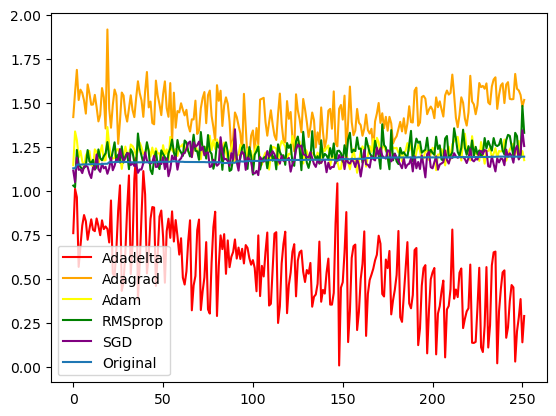

In [52]:
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']
colors = ['red', 'orange', 'yellow', 'green', 'purple']

for optimizer, color in zip(optimizers, colors):
  prediction = build_mlp(optimizer)
  r2 = r2_score(df_test.Beta.values, prediction)
  print(f'Wartość R^2 dla optimizera {optimizer} to {r2}')
  plt.plot(prediction, color=color, label=optimizer);

plt.plot(df_test.Beta.values, label='Original');    
plt.legend();

### LSTM

In [53]:
def build_lstm(opt):
    simple_lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(
            128, input_shape=X_train_w.shape[-2:], dropout=dropout),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(1)
    ])

    simple_lstm_model.compile(optimizer=opt, loss='mae')
    
    model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)

    lstm_pred = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
    
    return lstm_pred

Epoch 1/30
200/200 [==============================] - 11s 38ms/step - loss: 0.9057 - val_loss: 1.2006
Epoch 2/30
200/200 [==============================] - 8s 38ms/step - loss: 0.8751 - val_loss: 1.1445
Epoch 3/30
200/200 [==============================] - 7s 36ms/step - loss: 0.8425 - val_loss: 1.0837
Epoch 4/30
200/200 [==============================] - 8s 39ms/step - loss: 0.8084 - val_loss: 1.0188
Epoch 5/30
200/200 [==============================] - 7s 34ms/step - loss: 0.7726 - val_loss: 0.9506
Epoch 6/30
200/200 [==============================] - 7s 33ms/step - loss: 0.7355 - val_loss: 0.8763
Epoch 7/30
200/200 [==============================] - 7s 37ms/step - loss: 0.6974 - val_loss: 0.7967
Epoch 8/30
200/200 [==============================] - 7s 37ms/step - loss: 0.6581 - val_loss: 0.7128
Epoch 9/30
200/200 [==============================] - 7s 34ms/step - loss: 0.6173 - val_loss: 0.6258
Epoch 10/30
200/200 [==============================] - 8s 38ms/step - loss: 0.5753 - val_l

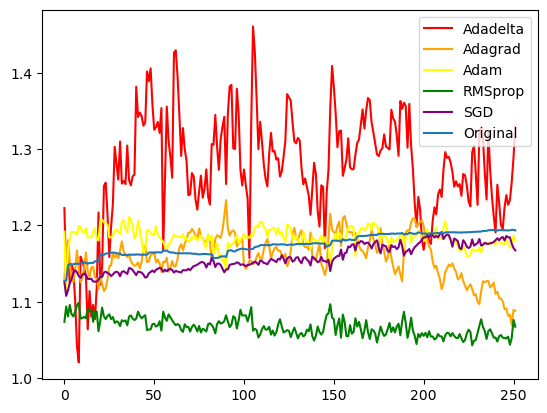

In [54]:
for optimizer, color in zip(optimizers, colors):
  prediction = build_lstm(optimizer)
  r2 = r2_score(df_test.Beta.values, prediction)
  print(f'Wartość R^2 dla optimizera {optimizer} to {r2}')
  plt.plot(prediction, color=color, label=optimizer);

plt.plot(df_test.Beta.values, label='Original');    
plt.legend();

## Różne kombinacje warstw dla LSTM

In [55]:
r2_scores = []
mse_scores = []
mae_scores = []

### Model 1: domyślna

In [56]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='SGD', loss='mae')

In [57]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 12s 45ms/step - loss: 0.1267 - val_loss: 0.1220
Epoch 2/30
200/200 [==============================] - 9s 45ms/step - loss: 0.0574 - val_loss: 0.1162
Epoch 3/30
200/200 [==============================] - 9s 44ms/step - loss: 0.0469 - val_loss: 0.0929
Epoch 4/30
200/200 [==============================] - 9s 46ms/step - loss: 0.0411 - val_loss: 0.0442
Epoch 5/30
200/200 [==============================] - 9s 47ms/step - loss: 0.0348 - val_loss: 0.0839
Epoch 6/30
200/200 [==============================] - 9s 47ms/step - loss: 0.0321 - val_loss: 0.0327
Epoch 7/30
200/200 [==============================] - 9s 46ms/step - loss: 0.0304 - val_loss: 0.0102
Epoch 8/30
200/200 [==============================] - 9s 45ms/step - loss: 0.0279 - val_loss: 0.0141
Epoch 9/30
200/200 [==============================] - 9s 46ms/step - loss: 0.0269 - val_loss: 0.0745
Epoch 10/30
200/200 [==============================] - 9s 46ms/step - loss: 0.0261 - val_l

In [58]:
lstm_pred = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]

r2_scores.append(r2_score(df_test.Beta.values, lstm_pred))
mae_scores.append(mean_absolute_error(df_test.Beta.values, lstm_pred))
mse_scores.append(mean_squared_error(df_test.Beta.values, lstm_pred))

8/8 [==============================] - 0s 5ms/step


### Model 2: jedna LSTM z 64 neuronami, dwie Dense z 64 neuronami i jedna Dense z 1

In [59]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        64, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='SGD', loss='mae')

In [60]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 4s 14ms/step - loss: 0.1179 - val_loss: 0.0499
Epoch 2/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0509 - val_loss: 0.0417
Epoch 3/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0434 - val_loss: 0.0330
Epoch 4/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0375 - val_loss: 0.1241
Epoch 5/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0343 - val_loss: 0.0269
Epoch 6/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0314 - val_loss: 0.0197
Epoch 7/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0296 - val_loss: 0.0267
Epoch 8/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0283 - val_loss: 0.0324
Epoch 9/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0257 - val_loss: 0.0237
Epoch 10/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0254 - val_lo

In [61]:
lstm_pred = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]

r2_scores.append(r2_score(df_test.Beta.values, lstm_pred))
mae_scores.append(mean_absolute_error(df_test.Beta.values, lstm_pred))
mse_scores.append(mean_squared_error(df_test.Beta.values, lstm_pred))

8/8 [==============================] - 1s 6ms/step


### Model 3: dwie LSTM z 128, dwie Dense z 128, jedna Dense z 1

In [62]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout, return_sequences=True),
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='SGD', loss='mae')

In [63]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 21s 84ms/step - loss: 0.1118 - val_loss: 0.0743
Epoch 2/30
200/200 [==============================] - 16s 81ms/step - loss: 0.0582 - val_loss: 0.0550
Epoch 3/30
200/200 [==============================] - 16s 80ms/step - loss: 0.0453 - val_loss: 0.0415
Epoch 4/30
200/200 [==============================] - 16s 81ms/step - loss: 0.0402 - val_loss: 0.0439
Epoch 5/30
200/200 [==============================] - 16s 80ms/step - loss: 0.0367 - val_loss: 0.0588
Epoch 6/30
200/200 [==============================] - 16s 81ms/step - loss: 0.0329 - val_loss: 0.0173
Epoch 7/30
200/200 [==============================] - 16s 81ms/step - loss: 0.0308 - val_loss: 0.0088
Epoch 8/30
200/200 [==============================] - 16s 81ms/step - loss: 0.0295 - val_loss: 0.0148
Epoch 9/30
200/200 [==============================] - 16s 81ms/step - loss: 0.0280 - val_loss: 0.0527
Epoch 10/30
200/200 [==============================] - 16s 80ms/step - loss: 0.028

In [64]:
lstm_pred = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]

r2_scores.append(r2_score(df_test.Beta.values, lstm_pred))
mae_scores.append(mean_absolute_error(df_test.Beta.values, lstm_pred))
mse_scores.append(mean_squared_error(df_test.Beta.values, lstm_pred))

8/8 [==============================] - 2s 31ms/step


### Model 4: jedna LSTM 128, jedna Desne 128, jedna Desne 1

In [65]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='SGD', loss='mae')

In [66]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 14s 58ms/step - loss: 0.1163 - val_loss: 0.1697
Epoch 2/30
200/200 [==============================] - 11s 56ms/step - loss: 0.0567 - val_loss: 0.0989
Epoch 3/30
200/200 [==============================] - 12s 61ms/step - loss: 0.0463 - val_loss: 0.0575
Epoch 4/30
200/200 [==============================] - 12s 58ms/step - loss: 0.0388 - val_loss: 0.0634
Epoch 5/30
200/200 [==============================] - 11s 56ms/step - loss: 0.0375 - val_loss: 0.0915
Epoch 6/30
200/200 [==============================] - 11s 57ms/step - loss: 0.0336 - val_loss: 0.0221
Epoch 7/30
200/200 [==============================] - 11s 55ms/step - loss: 0.0309 - val_loss: 0.0142
Epoch 8/30
200/200 [==============================] - 12s 59ms/step - loss: 0.0303 - val_loss: 0.0916
Epoch 9/30
200/200 [==============================] - 12s 61ms/step - loss: 0.0285 - val_loss: 0.0802
Epoch 10/30
200/200 [==============================] - 12s 61ms/step - loss: 0.026

In [67]:
lstm_pred = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]

r2_scores.append(r2_score(df_test.Beta.values, lstm_pred))
mae_scores.append(mean_absolute_error(df_test.Beta.values, lstm_pred))
mse_scores.append(mean_squared_error(df_test.Beta.values, lstm_pred))

8/8 [==============================] - 1s 13ms/step


### Model 5: jedna LSTM 256, dwie Dense 128, jedna Dense 1

In [68]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        256, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='SGD', loss='mae')

In [69]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 23s 100ms/step - loss: 0.1359 - val_loss: 0.1539
Epoch 2/30
200/200 [==============================] - 20s 98ms/step - loss: 0.0645 - val_loss: 0.0920
Epoch 3/30
200/200 [==============================] - 20s 98ms/step - loss: 0.0486 - val_loss: 0.0439
Epoch 4/30
200/200 [==============================] - 20s 99ms/step - loss: 0.0393 - val_loss: 0.0703
Epoch 5/30
200/200 [==============================] - 20s 99ms/step - loss: 0.0368 - val_loss: 0.0337
Epoch 6/30
200/200 [==============================] - 18s 90ms/step - loss: 0.0309 - val_loss: 0.0264
Epoch 7/30
200/200 [==============================] - 20s 99ms/step - loss: 0.0296 - val_loss: 0.0190
Epoch 8/30
200/200 [==============================] - 20s 98ms/step - loss: 0.0268 - val_loss: 0.0296
Epoch 9/30
200/200 [==============================] - 20s 98ms/step - loss: 0.0258 - val_loss: 0.0115
Epoch 10/30
200/200 [==============================] - 19s 97ms/step - loss: 0.02

In [70]:
lstm_pred = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]

r2_scores.append(r2_score(df_test.Beta.values, lstm_pred))
mae_scores.append(mean_absolute_error(df_test.Beta.values, lstm_pred))
mse_scores.append(mean_squared_error(df_test.Beta.values, lstm_pred))

8/8 [==============================] - 1s 24ms/step


### Model 6: jedna LSTM 256, dwie Dense 256, jedna Dense 1

In [71]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        256, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='SGD', loss='mae')

In [72]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 20s 84ms/step - loss: 0.1310 - val_loss: 0.1386
Epoch 2/30
200/200 [==============================] - 17s 87ms/step - loss: 0.0594 - val_loss: 0.0822
Epoch 3/30
200/200 [==============================] - 18s 89ms/step - loss: 0.0465 - val_loss: 0.0545
Epoch 4/30
200/200 [==============================] - 18s 90ms/step - loss: 0.0387 - val_loss: 0.0385
Epoch 5/30
200/200 [==============================] - 18s 90ms/step - loss: 0.0360 - val_loss: 0.0375
Epoch 6/30
200/200 [==============================] - 18s 92ms/step - loss: 0.0313 - val_loss: 0.0382
Epoch 7/30
200/200 [==============================] - 18s 92ms/step - loss: 0.0298 - val_loss: 0.0181
Epoch 8/30
200/200 [==============================] - 18s 92ms/step - loss: 0.0283 - val_loss: 0.0230
Epoch 9/30
200/200 [==============================] - 18s 92ms/step - loss: 0.0261 - val_loss: 0.0258
Epoch 10/30
200/200 [==============================] - 19s 93ms/step - loss: 0.025

In [73]:
lstm_pred = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]

r2_scores.append(r2_score(df_test.Beta.values, lstm_pred))
mae_scores.append(mean_absolute_error(df_test.Beta.values, lstm_pred))
mse_scores.append(mean_squared_error(df_test.Beta.values, lstm_pred))

8/8 [==============================] - 1s 25ms/step


### Wykresy błędów

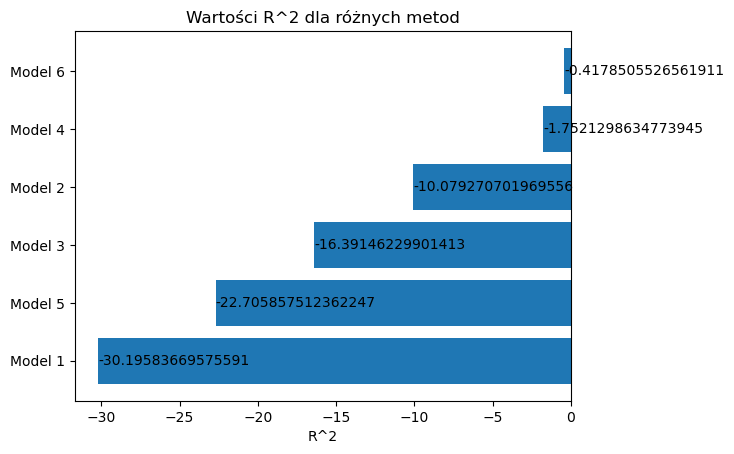

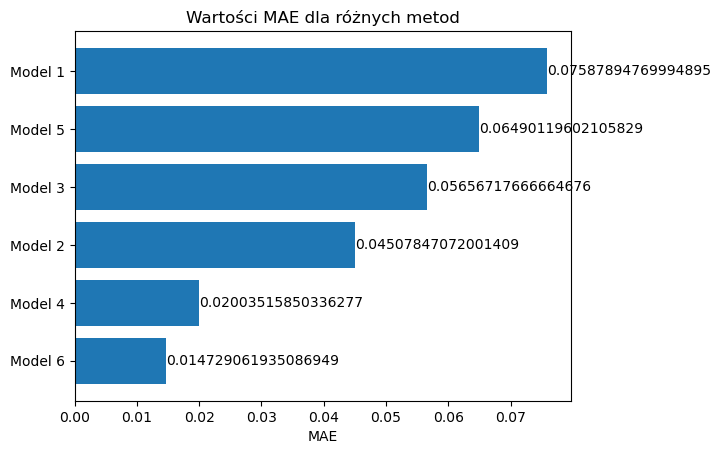

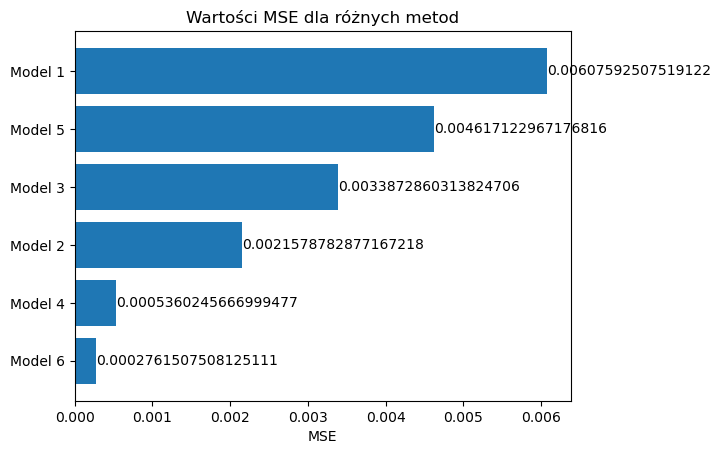

In [74]:
scores_list = [r2_scores, mae_scores, mse_scores]
names_list = ['R^2', 'MAE', 'MSE']
methods = ['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6']

for scores, name in zip(scores_list, names_list):
    sorted_data = sorted(zip(scores, methods))

    sorted_r2_scores, sorted_methods = zip(*sorted_data)
    
    plt.barh(range(len(sorted_r2_scores)), sorted_r2_scores)

    plt.yticks(range(len(sorted_methods)), sorted_methods)

    for i, score in enumerate(sorted_r2_scores):
        plt.text(score, i, str(score), ha='left', va='center')

    plt.title(f'Wartości {name} dla różnych metod')
    plt.xlabel(name)

    plt.show()